In [13]:
#importing packages
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras import layers, applications, optimizers
from keras import regularizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, ZeroPadding2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import ndimage, misc

from imgaug import augmenters as iaa
import imgaug as ia

import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random
import pickle
import cv2
import os
import argparse
import re
from PIL import Image
from numpy import *
from glob import glob
from datetime import datetime
from shutil import copyfile
 
import pandas as pd    
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell #multiple outputs in notebook
InteractiveShell.ast_node_interactivity = "all"            #

random.seed(42)

In [2]:
# optional
dir_dataset = "/Users/annaleid/Documents/Jordy Final/Dataset Seils/notes_aug_seils"

In [3]:
def plotImages(images_arr, name):
    random.shuffle(images_arr)
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'), cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig('{}.png'.format(name))

In [ ]:
#google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
#google Colab
!unzip drive/My\ Drive/notes_aug_heavy_seils.zip

OUTPUT = "notes_aug_heavy_seils/"

In [4]:
# initialize image dimensions
IMAGE_DIMS = (158, 100, 3)
scale_percent = 100

width = int(IMAGE_DIMS[1] * scale_percent / 100)
height = int(IMAGE_DIMS[0] * scale_percent / 100)

In [6]:
# grab the image paths and randomly shuffle them
random.seed(42)
imagePaths = sorted(list(paths.list_images(dir_dataset)))
random.shuffle(imagePaths)

# initialize the data and labels
images_train = []
data_train = []
noteLabels = []
durationLabels = []

# create preprocessed lists of images
for imagePath in imagePaths:
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (width, height))
    ret1, image = cv2.threshold(image,127,255,cv2.THRESH_OTSU)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) #TL model needs colored, 3 channel images as input
    image = ndimage.median_filter(image, size=2)
    images_train.append(image)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    data_train.append(image)
    
    # extract set of class labels from the image path and update the labels
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|maxima|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels.append(note)
    durationLabels.append(duration)

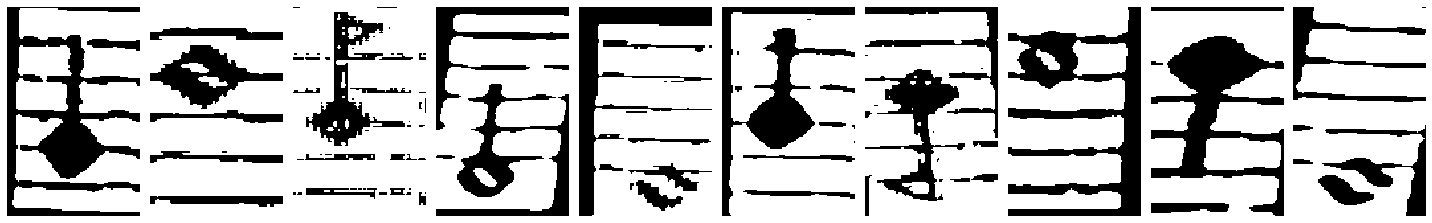

In [7]:
plotImages(images_train, 'images_train')

In [8]:
data_train = np.array(data_train)

# do some checks
data_train.shape
set(noteLabels)
set(durationLabels)
len(set(map(len, (data_train, noteLabels, durationLabels)))) == 1 #check if length of lists is the same

(18300, 158, 100, 3)

{"a'", "b'", "c''", "d'", "d''", "e'", "e''", "f'", "f''", "g'", "g''"}

{'1', '2', '4', '8', 'breve', 'longa'}

True

In [9]:
# convert the label lists to NumPy arrays prior to binarization
noteLabels = np.array(noteLabels)
durationLabels = np.array(durationLabels)
 
# binarize both sets of labels
noteLB = LabelBinarizer()
durationLB = LabelBinarizer()
noteLabels = noteLB.fit_transform(noteLabels)
durationLabels = durationLB.fit_transform(durationLabels)

trainX, testX, trainNoteY, testNoteY, trainDurationY, testDurationY = train_test_split(data_train,
                                    noteLabels, durationLabels, random_state=666, train_size=0.75)

In [10]:
# do some checks

print("We have {} training images and {} test images, with a total of {} images. The images have a height of {} and a width of {} with {} channel(s). There are {} different note classes and {} different duration classes.".format(trainX.shape[0], testX.shape[0], data_train.shape[0], data_train.shape[1], data_train.shape[2], data_train.shape[3], trainNoteY.shape[1], trainDurationY.shape[1]))

We have 13725 training images and 4575 test images, with a total of 18300 images. The images have a height of 158 and a width of 100 with 3 channel(s). There are 11 different note classes and 6 different duration classes.


# Transfer Model

In [11]:
base_model = applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (158, 100, 3))

In [15]:
for layer in base_model.layers[:17]:
    layer.trainable = False

In [16]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1c51703a90>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d62090710>,conv2d,False
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1d5b817128>,batch_normalization,False
3,<tensorflow.python.keras.layers.core.Activation object at 0x1d5b868240>,activation,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d5b8681d0>,conv2d_1,False
5,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1cc8c9c898>,batch_normalization_1,False
6,<tensorflow.python.keras.layers.core.Activation object at 0x1cd8d8bd30>,activation_1,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1d5b877b70>,conv2d_2,False
8,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1c51694358>,batch_normalization_2,False
9,<tensorflow.python.keras.layers.core.Activation object at 0x1c516a1048>,activation_2,False


In [17]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
note_output = Dense(len(noteLB.classes_), activation='softmax', name = "note_output")(x)
duration_output = Dense(len(durationLB.classes_), activation='softmax', name = "duration_output")(x)

model = Model(inputs=base_model.input, outputs=[note_output, duration_output])

In [ ]:
# do some checks
model.summary()
model.input_shape
model.output_shape

In [18]:
# compile model
epochs = 80
batch_size = 128

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "note_output": "categorical_crossentropy",
    "duration_output": "categorical_crossentropy",}
lossWeights = {"note_output": 1.0, "duration_output": 1.0}
 
# initialize the optimizer and compile the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
nadam = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=rms, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [19]:
# callbacks
early_stopping = EarlyStopping(monitor='val_note_output_acc', patience=8, mode = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_loss', factor=0.3, min_lr=0.00001, cooldown=1, verbose=1)

checkpoint = ModelCheckpoint("/Users/annaleid/Documents/Jordy/Trained Models/",
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)

In [20]:
# # train the network to perform multi-output classification
H = model.fit(trainX, {"note_output": trainNoteY, "duration_output": trainDurationY},
    validation_data=(testX, {"note_output": testNoteY, "duration_output": testDurationY}),
    epochs=epochs,
    verbose=1,
    callbacks = [reduce_lr, early_stopping])

Train on 13725 samples, validate on 4575 samples
Epoch 1/80
 8704/13725 [==================>...........] - ETA: 3:57 - loss: 3.1436 - note_output_loss: 2.0653 - duration_output_loss: 1.0783 - note_output_accuracy: 0.2424 - duration_output_accuracy: 0.5684WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,note_output_loss,duration_output_loss,note_output_accuracy,duration_output_accuracy,lr


KeyboardInterrupt: 

In [ ]:
n_epochs = len(H.history['loss'])

# plot the total loss, category loss, and color loss
lossNames = ["loss", "note_output_loss", "duration_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
 
# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, n_epochs), H.history[l], label=l)
    ax[i].plot(np.arange(0, n_epochs), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

In [ ]:
# create a new figure for the accuracies
accuracyNames = ["note_output_acc", "duration_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
 
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, n_epochs), H.history[l], label=l)
    ax[i].plot(np.arange(0, n_epochs), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the accuracies figure
plt.tight_layout()

In [ ]:
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
(eval_loss_note, eval_accuracy_note) = model.evaluate(  
 validation_data, testNoteY, batch_size=batch_size, verbose=1)
(eval_loss_duration, eval_accuracy_duration) = model.evaluate(  
 validation_data, testDurationY, batch_size=batch_size, verbose=1)

print("[INFO] Note accuracy: {:.2f}%".format(eval_accuracy_note * 100))  
print("[INFO] Note Loss: {}".format(eval_loss_note)) 
print("[INFO] Duration accuracy: {:.2f}%".format(eval_accuracy_duration * 100))  
print("[INFO] Duration Loss: {}".format(eval_loss_duration)) 

# Test Images

In [ ]:
#Google Colab
!unzip drive/My\ Drive/testimages.zip

In [ ]:
folder_test = "testimages/"
imagePaths = sorted(list(paths.list_images(folder_test)))

##### Create list with arrays and labels of test images

# initialize the data and labels
images_test_original = []
images_test = []
data_test = []
noteLabels_test = []
durationLabels_test = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    images_test_original.append(image)
    image = cv2.resize(image, (width, height))
    ret1, image = cv2.threshold(image, 127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image = ndimage.median_filter(image, size=1)
    images_test.append(image)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    data_test.append(image)
    
    # extract set of class labels from the image path and update the labels
    # update the respective lists
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|maxima|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels_test.append(note)
    durationLabels_test.append(duration)

In [ ]:
plotImages(images_test_original, 'test_original')

In [ ]:
plotImages(images_test, 'test_preprocessed')

In [ ]:
data_test = np.array(data_test)

In [ ]:
set(noteLabels_test)
set(durationLabels_test)
len(set(map(len, (data_test, noteLabels_test, durationLabels_test)))) == 1 #check if length of lists is the same

In [ ]:
# convert the label lists to NumPy arrays prior to binarization
noteLabels_test = np.array(noteLabels_test)
durationLabels_test = np.array(durationLabels_test)
 
# binarize both sets of labels
noteLabels_test = noteLB.transform(noteLabels_test)
durationLabels_test = durationLB.transform(durationLabels_test)

In [ ]:
# double check if testimages are correctly labeled

noteLB.inverse_transform(noteLabels_test)[0]
durationLB.inverse_transform(durationLabels_test)[0]

plt.imshow(np.squeeze(data_test[0]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[1]
durationLB.inverse_transform(durationLabels_test)[1]

plt.imshow(np.squeeze(data_test[1]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[15]
durationLB.inverse_transform(durationLabels_test)[15]

plt.imshow(np.squeeze(data_test[15]), cmap = 'gray')
plt.show()

In [ ]:
# classify test images with model
scores = model.evaluate(data_test, [noteLabels_test, durationLabels_test], verbose=0)

# print scores
for i, j in zip(model.metrics_names, scores):
    print(i,'=', j)

In [ ]:
(eval_loss_note, eval_accuracy_note) = model.evaluate(  
 data_test, noteLabels_test, batch_size=batch_size, verbose=1)
(eval_loss_duration, eval_accuracy_duration) = model.evaluate(  
 data_test, durationLabels_test, batch_size=batch_size, verbose=1)

print("[INFO] Note accuracy: {:.2f}%".format(eval_accuracy_note * 100))  
print("[INFO] Note Loss: {}".format(eval_loss_note)) 
print("[INFO] Duration accuracy: {:.2f}%".format(eval_accuracy_duration * 100))  
print("[INFO] Duration Loss: {}".format(eval_loss_duration)) 